In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)}) 

from cryptocompare import get_daily_trade_hist

So bitcoin is going on a tear today and is nearly up 10% in 24 hours. Let's look at the historical precedent for these movements and see whether or not there are any patterns that emerge.

In [3]:
btc_trades = get_daily_trade_hist('BTC', all_data=True)
btc_trades.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902
2010-07-18,0.08584,0.08585,0.05941,0.04951,75.01,5.0900
2010-07-19,0.08080,0.09307,0.07723,0.08584,574.00,49.6600
2010-07-20,0.07474,0.08181,0.07426,0.08080,262.00,20.5900
2010-07-21,0.07921,0.07921,0.06634,0.07474,575.00,42.2600


In [4]:
TODAY = datetime(2018,7,17)

Let's add intraday swing data as well as return for several periods:

In [5]:
btc_trades['intraday_swing'] = (btc_trades.high - btc_trades.low) / btc_trades.open

for days in [1, 2, 3, 5, 8, 13, 21, 34]:
    col = 'returns_{}d'.format(days)
    btc_trades[col] = btc_trades.close.pct_change(days)

In [6]:
btc_trades.tail(1)

,close,high,low,open,volumefrom,volumeto,intraday_swing,returns_1d,returns_2d,returns_3d,returns_5d,returns_8d,returns_13d,returns_21d,returns_34d
time,,,,,,,,,,,,,,,
2018-07-18,7420.35,7553.08,7326.19,7326.76,55984.88,4.181692e+08,0.030967,0.012782,0.100852,0.165941,0.1911,0.176554,0.135511,0.208217,0.116974


In [7]:
def plot_hist(df, feature, start=None, end=None):
    data = df[start:end][feature].dropna()
    sns.distplot(data,kde=False)
    todays_val = df.ix[TODAY][feature]
    mean = data.mean()
    feature_label = feature.replace('_',' ')
    plt.axvline(todays_val, label="Today's {} ({})".format(feature_label, round(todays_val,4)), color='yellow')
    plt.axvline(mean, label='Mean {} ({})'.format(feature_label, round(mean ,4)), color='black', ls='--')
    mean_multiple = round(todays_val/mean,2)
    plt.title("Today's {} is {} times the mean.".format(feature_label, mean_multiple))
    plt.legend() 
    plt.show()

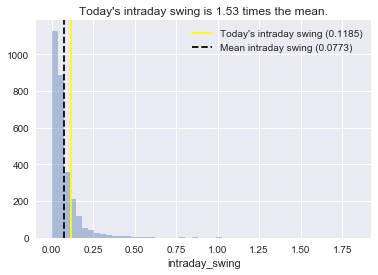

In [8]:
plot_hist(btc_trades, 'intraday_swing')

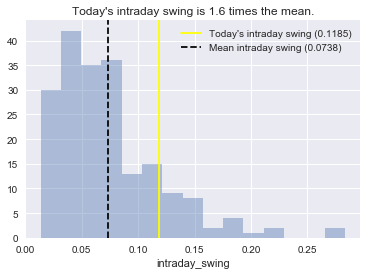

In [9]:
plot_hist(btc_trades, 'intraday_swing', start=datetime(2018,1,1))

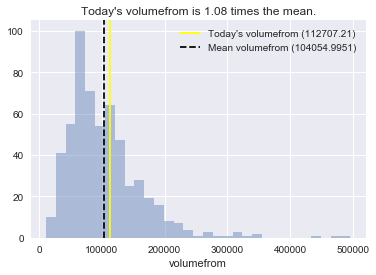

In [11]:
plot_hist(btc_trades, 'volumefrom', start=datetime(2017,1,1))

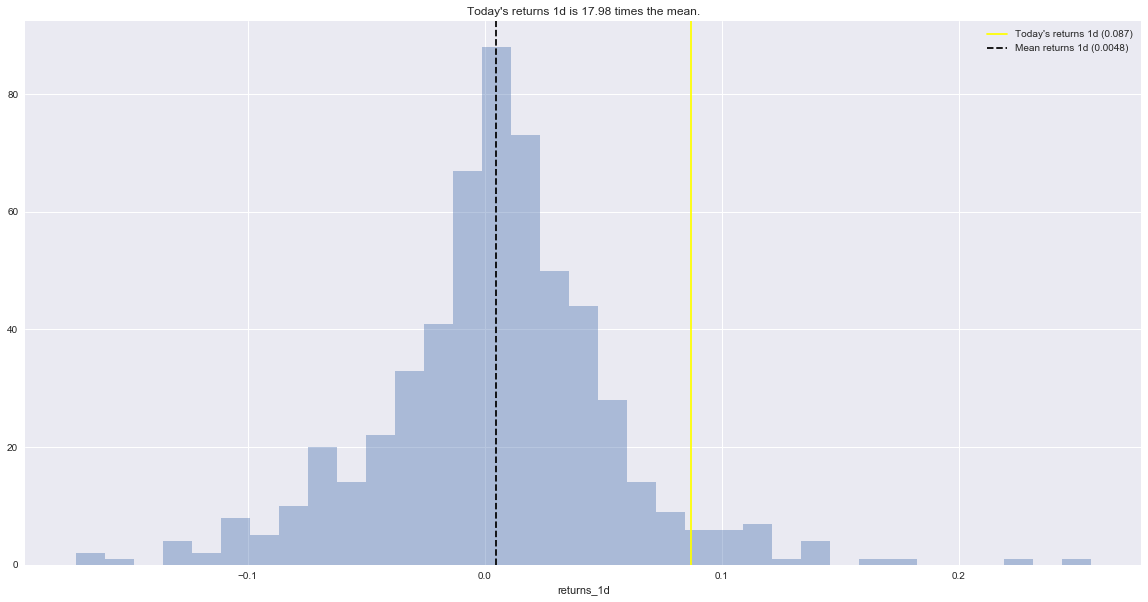

In [186]:
plot_hist(btc_trades, 'returns_1d', start=datetime(2017,1,1))

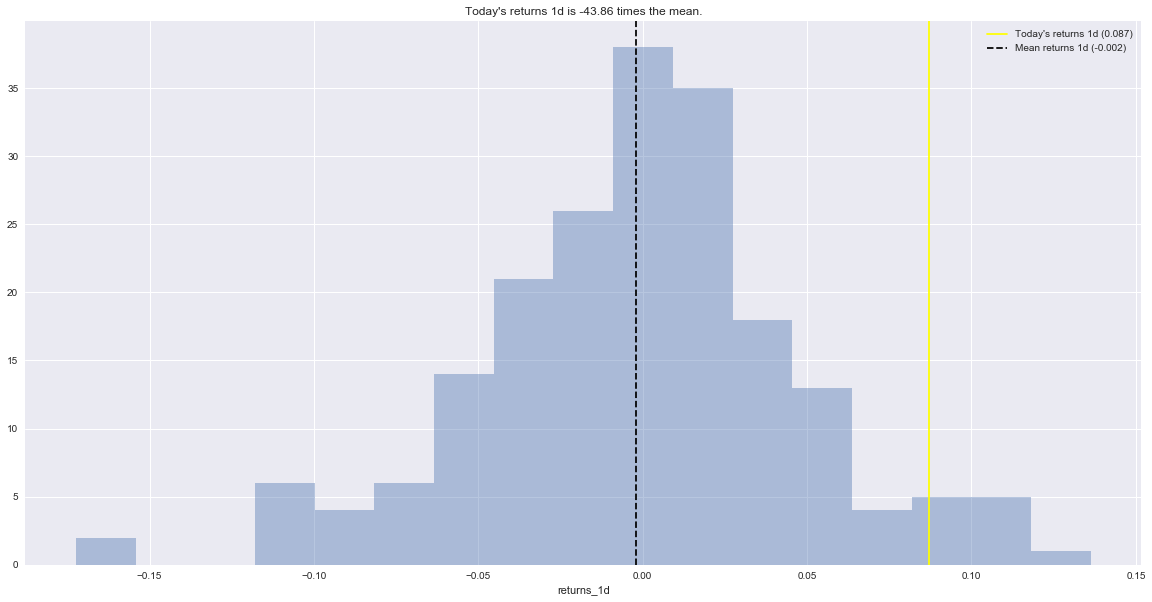

In [187]:
plot_hist(btc_trades, 'returns_1d', start=datetime(2018,1,1))

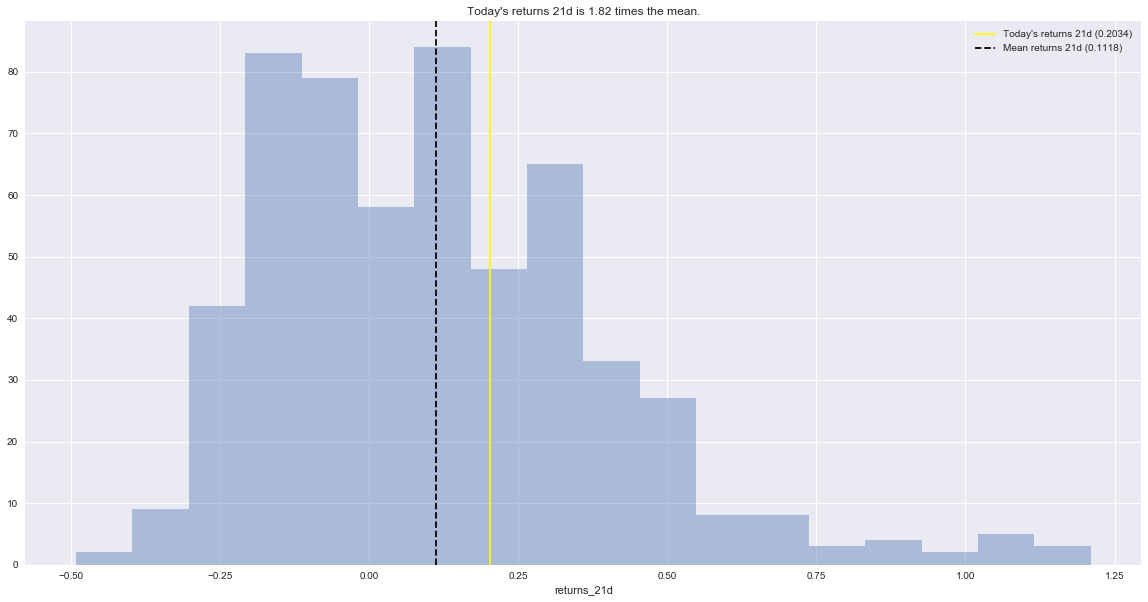

In [188]:
plot_hist(btc_trades, 'returns_21d', start=datetime(2017,1,1))

In [200]:
for col in btc_trades.columns:
    if 'returns' not in col:
        continue
    
    new_col = 'future_{}'.format(col)
    days = int(col.split('_')[1].replace('d',''))
    btc_trades[new_col] = btc_trades[col].shift(-days)

ValueError: invalid literal for int() with base 10: 'returns'

In [190]:
comp_gains = btc_trades[btc_trades.returns_1d>=btc_trades.ix[TODAY].returns_1d]

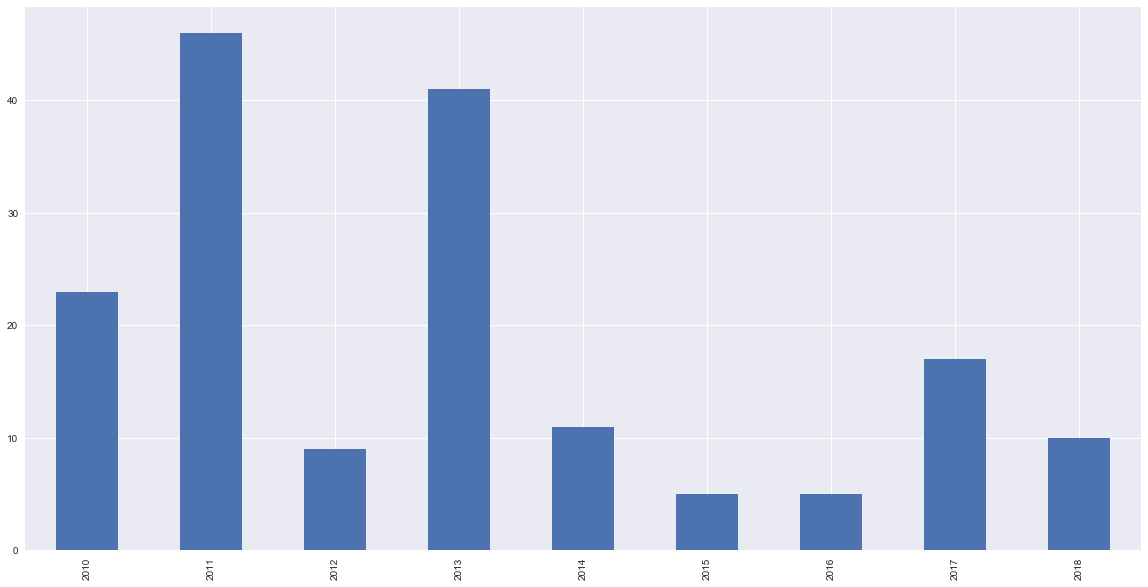

In [191]:
groupby_year = comp_gains.groupby(comp_gains.index.year)
groupby_year.close.count().plot(kind='bar')

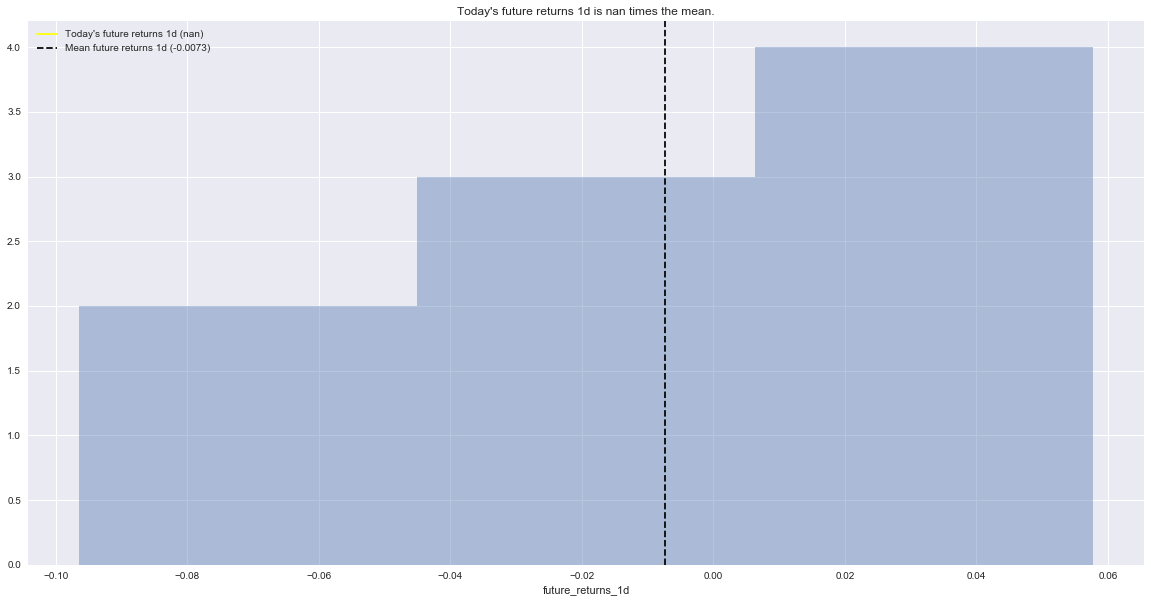

In [199]:
plot_hist(comp_gains, 'future_returns_1d', start=datetime(2018,1,1))

In [215]:
future_return_cols = [c for c in comp_gains.columns if 'future' in c]

comp_gains[:datetime(2018,1,1)][future_return_cols]

,future_returns_1d,future_returns_2d,future_returns_3d,future_returns_5d,future_returns_8d,future_returns_13d,future_returns_21d,future_returns_34d
time,,,,,,,,
2010-07-18,-0.058714,-0.129310,-0.077237,-0.270503,-0.347623,-0.209576,-0.290541,-0.226468
2010-07-23,-0.129032,-0.193548,-0.105717,-0.059406,0.083520,-0.025870,0.030022,0.022038
2010-07-26,0.071429,0.051786,0.248214,0.211607,0.071429,0.087500,0.169643,0.142857
2010-07-29,-0.103004,-0.029328,-0.125894,-0.141631,-0.108727,-0.041488,-0.045780,-0.100143
2010-08-09,-0.014085,-0.056338,-0.014085,-0.056338,-0.014085,-0.070423,-0.084930,-0.133803
2010-10-08,0.080023,0.111111,0.093840,0.208981,0.162925,0.232009,1.187680,1.568797
2010-10-13,-0.028571,0.000000,-0.038095,-0.024762,0.019048,0.431429,0.839048,1.123810
2010-10-24,0.147826,0.306957,0.632174,0.652174,0.700000,2.391304,1.426087,1.460870
2010-10-25,0.138636,0.421970,0.311364,0.506818,0.468182,1.575758,1.031818,1.045455


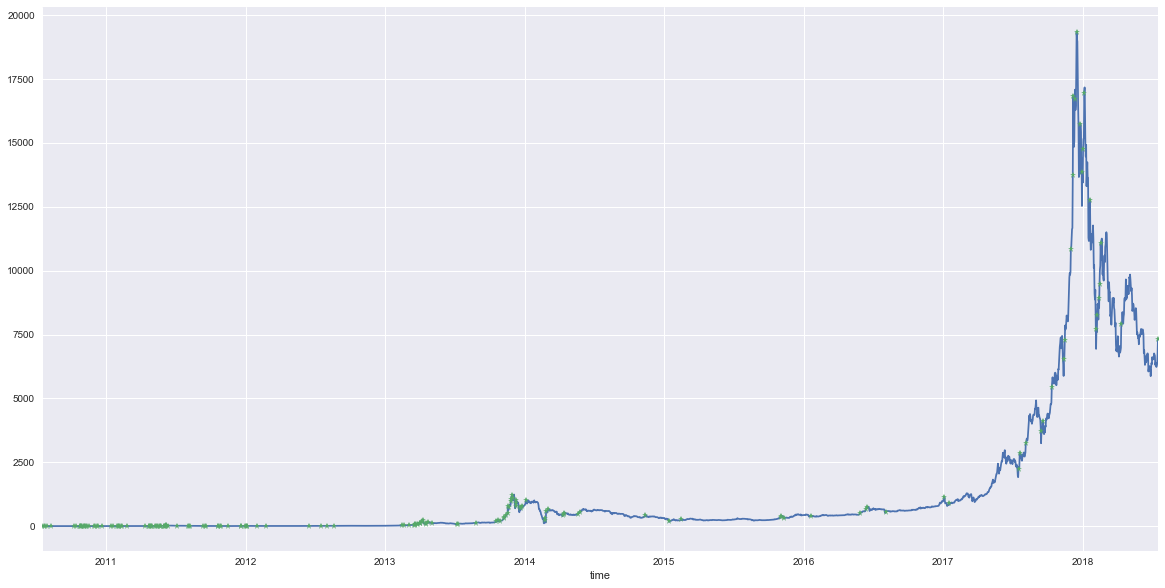

In [193]:
btc_trades.close.plot()
comp_gains.close.plot(marker='*', ls='')

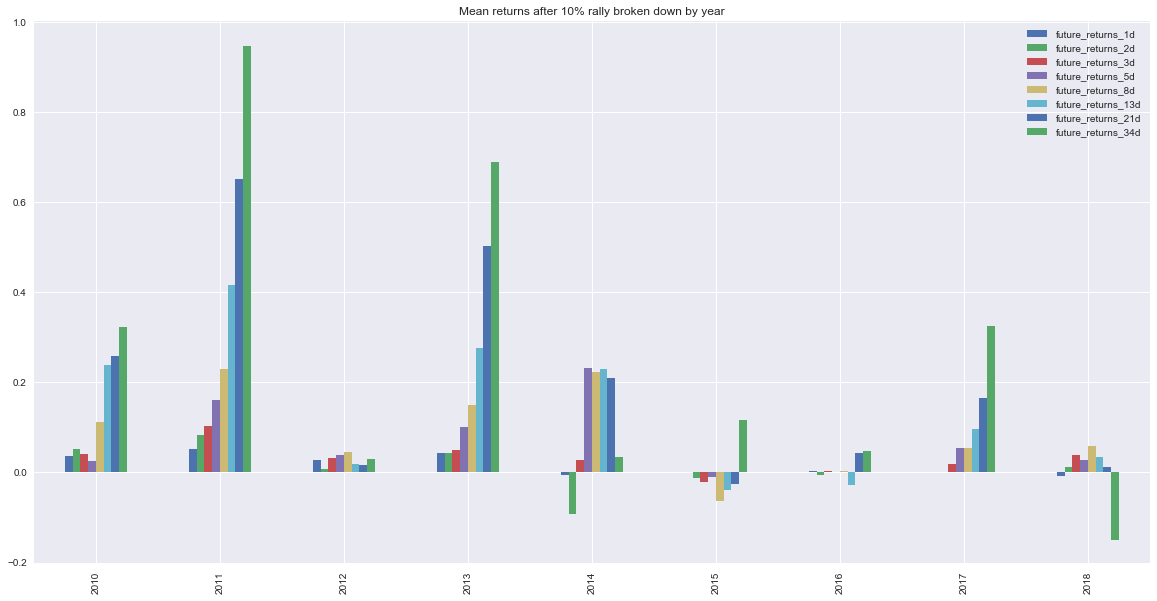

In [217]:
groupby_year[future_return_cols].mean().plot(kind='bar', title='Mean returns after 10% rally broken down by year')
#plt.legend()

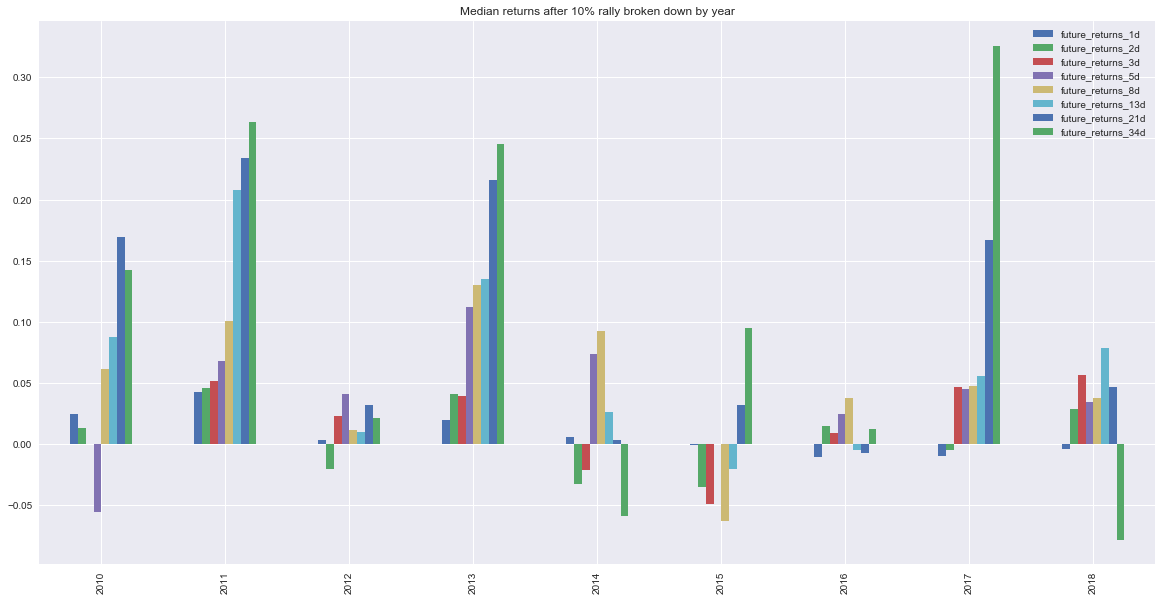

In [221]:
groupby_year[future_return_cols].median().plot(kind='bar', title='Median returns after 10% rally broken down by year')

In [18]:
for days in [1, 2, 3, 5, 8, 13, 21, 34]:
    col = 'returns_{}d'.format(days)
    btc_trades[col] = btc_trades.close.pct_change(days)

In [ ]:
btc_trades[btc_trades.pct_change(1) > 0.9]